<a href="https://colab.research.google.com/github/yazimberiluluer/CNN-with-Pythorch-for-MNIST/blob/main/Convolutional_Neural_Network_with_Pythorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import cv2
import torch
import torch.nn as nn #torc hu nn üzeirnden kullanıyoruz
import torchvision.transforms as transforms
import torchvision.datasets as datasets #eğitim yaparken tüm verisetlerini locale indirmek vs ile uğraşmamak için
from torch.autograd import Variable #bunun içinden variables alıyor(?)
from torch.utils.data  import DataLoader, Dataset #torch içindeki yardımcı araçlar-> utilste

import matplotlib.pyplot as plt
from PIL import Image #PIL= Python Imaging Library ->bak
import numpy as np 

from google.colab.patches import cv2_imshow


In [25]:
#precomputed mean and stdev 
mean_gray = 0.1307
stdev_gray = 0.3081
#transforms the image to tensors 
transforms_original = transforms.Compose([transforms.ToTensor(),
                    transforms.Normalize((mean_gray,),(stdev_gray,))])  #resim dönüşümü için trnasofrmsu kullanmıştık, compose da zincirliyo
transforms_photo = transforms.Compose([transforms.Resize((28,28)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((mean_gray,), (stdev_gray,))])

#Load Dataset

In [26]:
train_dataset = datasets.MNIST(root = './data',
                               train = True,
                               transform = transforms_original,
                               download = True)
test_dataset = datasets.MNIST(root = './data',
                               train = False,
                               transform = transforms_original,)

#Random Imagee

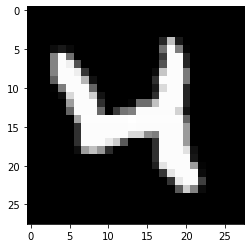

In [27]:
import matplotlib.pyplot as plt
# Data
random_image = train_dataset[20][0].numpy() * stdev_gray + mean_gray
plt.imshow(random_image.reshape(28,28), cmap='gray') #20 -> verinin indexi ,0 -> kendisini geitr demek

In [28]:
# Label
print(train_dataset[20][1])

4


In [29]:
# Iterable Dataset

batch_size = 100 #her iterasyon için kaç tane göndericeksin
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size,
                                          shuffle = False)

In [30]:
len(train_loader) #60000 i 100 er 100 er ayırdık çünkü batch_size la

600

In [31]:
len(test_loader)

100

In [32]:
len(train_dataset)

60000

In [33]:
print('Training Set (images) : {}'.format(len(train_dataset)))
print('Test Set (images) : {}'.format(len(test_dataset)))
print('Train Loader Batches :  {}'.format(len(train_loader)))
print('Test Loader Batches : {}'.format(len(test_loader)))

Training Set (images) : 60000
Test Set (images) : 10000
Train Loader Batches :  600
Test Loader Batches : 100


# Model Class

In [34]:
class CNN(nn.Module): #nn den kalıtım aldık
  def __init__(self):
    super(CNN, self).__init__() 
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3,stride=1, padding=1)
    #nn modülündeki con2d metodunu kullanıyoruz -> parametreleri var
    #PARAMETRELERİN AÇIKLAMALARINI BURAYA YAZ
    self.batchnorm1 = nn.BatchNorm2d(8) # batch normalization ile ağdaki katmanlar
    #önceki katmanların öğrenmesini beklemek zorunda kalmadan eş zamanlı öğrenme gerçekleşir
    #(eğitimi hızlandırmak için yani)
    #ANLAMADIM -> sonuçta hidden layerların outputu diğerinin inputu nasıl beklemiyo?
    # 8 olmasının nedeni, batch norm. nn ün sonuna eklenir ve aldığı parametre nn ün output channells parametresinin boyutu kadar olmalıymış ->why
    self.relu = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)

    #MaxPool dan sonra her output feature map i 14 (28*28 lik ti, 28/2 -> 2 sanırım kernel size dan)

    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
    self.batchnorm2 = nn.BatchNorm2d(32)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)

    #MaxPool dan sonra her feature map 7 (14 tü en son 14/2)
    #Feature mapleri flattenladık -> vektör haline getirdik yani
      #32 feature map var(?) ve her biri 7*7 lik
      #32*7*7=1568 yani şu an[1,1568] lik vektör oldu sonra bunu fully connected katmanına veriyoruz

    self.fc1 = nn.Linear(in_features=1568, out_features=600)
    self.dropout = nn.Dropout(p=0.5) #ezberlemeyi engelliyormuş
    #bir önceki katman bir sonrakine bir şeyler gönderiyor, dropout uygulandığında dropoutun yüzdesine göre
    #random bazı nöronlara input göndermiyor yani o nöornların değerleini yokediyor -> 0.5 bunun oranı işte 
    #nöronların yarısının değerlerini sil
    self.fc2 = nn.Linear(in_features=600, out_features=10) #out_feature 10 çünkü 0-9 arasında 10 farklı sınıf var
  
  def forward(self, x):
    x = self.cnn1(x)
    x = self.batchnorm1(x)
    x = self.relu(x)
    x = self.maxpool1(x)
    x = self.cnn2(x)
    x = self.batchnorm2(x)
    x = self.maxpool2(x)
    x = x.view(-1,1568)  # BU NE???
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    return x


In [35]:
model = CNN() #CNN classının nesnesini oluşturduk
CUDA = torch.cuda.is_available() #cudayı kotnrol etmek için aktif mi vs
if CUDA:
  model = model.cuda() #her bir nesnein cuda diye bir fonksiyonu var ve eğer cuda aktifse 
  #yani sistemde NVIDIA kartları ve cuda sorunsuz kuruluysa hesaplamayı GPU üzerinde yap yani modeli GPU dan çalıştır
  #is_available() ile bunu sorugladık
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01) #anlamadım


In [36]:
iteration = 0
correct = 0

for i,(inputs, labels) in enumerate(train_loader): #inputlar train_loader dan geliyor
#train_loader da belirlediğimiz batch_size ile iterasyon yapılacak şekilde parça parça veriyor

  CUDA = torch.cuda.is_available()
  if CUDA:
    inputs = inputs.cuda()
    labels = labels.cuda()

    print("Her bir iterasyonda...")
    print("Input Shape:  ", inputs.shape)
    print("Labels Shape: ", labels.shape)
    output = model(inputs)
    print("Output Shape:  ", output.shape) 
    _, predicted = torch.max(output,1)  # -> BU SATIRI ANLAMADIM
    print("Predicted Shape: ", predicted.shape)
    print("Predicted Tensor: ")
    print(predicted)
    correct += (predicted == labels).sum()
    break

Her bir iterasyonda...
Input Shape:   torch.Size([100, 1, 28, 28])
Labels Shape:  torch.Size([100])
Output Shape:   torch.Size([100, 10])
Predicted Shape:  torch.Size([100])
Predicted Tensor: 
tensor([1, 9, 9, 8, 8, 8, 1, 8, 8, 6, 6, 6, 6, 6, 6, 8, 6, 6, 8, 8, 8, 8, 6, 6,
        6, 9, 6, 9, 9, 9, 8, 6, 6, 2, 8, 9, 8, 6, 8, 9, 6, 8, 6, 9, 9, 8, 8, 3,
        9, 9, 6, 6, 8, 8, 6, 9, 6, 6, 8, 7, 8, 7, 6, 9, 8, 9, 8, 6, 6, 6, 6, 8,
        6, 6, 6, 8, 8, 8, 6, 9, 8, 9, 6, 8, 9, 6, 6, 3, 6, 8, 6, 7, 6, 8, 9, 8,
        3, 8, 8, 6], device='cuda:0')


# Training the Model

In [37]:
num_epochs = 25
#loss ve accuracy değerlerini lisstelerde tutuyoruz
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs): #burası 25 kez çalışıyo
  correct = 0
  iterations = 0
  iter_loss = 0.0

  model.train()

  for i,(inputs,labels) in enumerate(train_loader): #burası 600 kez çalışıyo
    CUDA = torch.cuda.is_available()
    if CUDA:
      inputs = inputs.cuda()
      labels = labels.cuda()
    
    outputs = model(inputs)
    loss = loss_fn(outputs,labels)
    #burada hesapladığımız loss değerini kaybetmemek için iter_loss aatıcaz
    iter_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #update the weights

    _, predicted = torch.max(outputs,1)
    correct += (predicted == labels).sum()
    iterations += 1
  
  train_loss.append(iter_loss/iterations)
  train_accuracy.append((100*correct / len(train_dataset)))

  testing_loss = 0.0
  correct = 0
  iterations = 0

  model.eval() #nn ü evaluation moda yani değerlendirme ye sokacak

  for i, (inputs,labels) in enumerate(test_loader):
    if CUDA:
      inputs = inputs.cuda()
      labels = labels.cuda()
    
    outputs = model(inputs)
    loss = loss_fn(outputs,labels)
    testing_loss += loss.item()
     
    _, predicted = torch.max(outputs,1)
    correct += (predicted == labels).sum()
    iterations += 1
  
  test_loss.append(testing_loss/iterations)
  test_accuracy.append((100*correct/len(test_dataset)))

  print('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Accuracy: {:.3f}'
  .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]))


Epoch 1/25, Training Loss: 0.438, Training Accuracy: 88.535, Testing Loss: 0.137, Testing Accuracy: 96.130
Epoch 2/25, Training Loss: 0.150, Training Accuracy: 95.745, Testing Loss: 0.090, Testing Accuracy: 97.190
Epoch 3/25, Training Loss: 0.113, Training Accuracy: 96.723, Testing Loss: 0.071, Testing Accuracy: 97.900
Epoch 4/25, Training Loss: 0.092, Training Accuracy: 97.302, Testing Loss: 0.061, Testing Accuracy: 98.100
Epoch 5/25, Training Loss: 0.079, Training Accuracy: 97.692, Testing Loss: 0.055, Testing Accuracy: 98.390
Epoch 6/25, Training Loss: 0.070, Training Accuracy: 97.932, Testing Loss: 0.050, Testing Accuracy: 98.370
Epoch 7/25, Training Loss: 0.063, Training Accuracy: 98.175, Testing Loss: 0.045, Testing Accuracy: 98.510
Epoch 8/25, Training Loss: 0.058, Training Accuracy: 98.255, Testing Loss: 0.045, Testing Accuracy: 98.510
Epoch 9/25, Training Loss: 0.053, Training Accuracy: 98.448, Testing Loss: 0.041, Testing Accuracy: 98.630
Epoch 10/25, Training Loss: 0.051, Tr

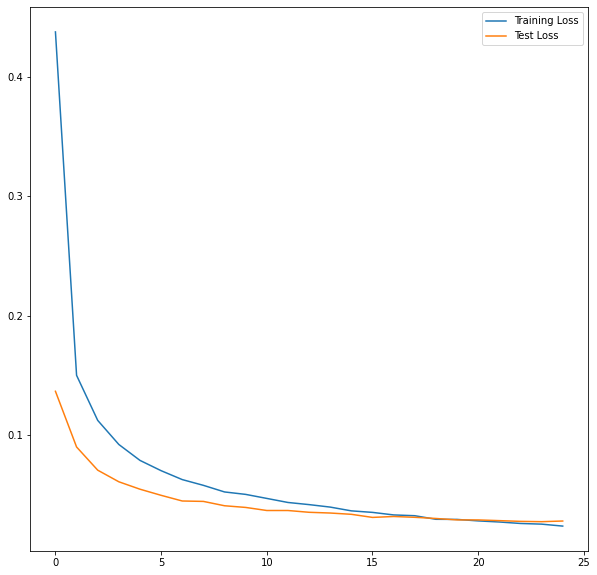

In [38]:
# Plotting the Loss
fig = plt.figure(figsize=(10,10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend()
plt.show()


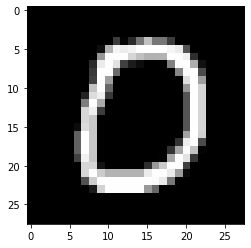

In [39]:
plt.imshow(test_dataset[10][0].reshape(28,28), cmap='gray')

In [45]:
def predict(img_name, model):
  image = cv2.imread(img_name, 0)
  ret,thresholded = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
  img = 255-thresholded
  cv2_imshow(img)
  cv2.waitKey(0)
  cv2.destroyAllWindows()
  img = Image.fromarray(img)
  img = transforms_photo(img)
  img = img.view(1, 1, 28, 28)
  img = Variable(img)

  model.eval()

  if torch.cuda.is_available():
    model = model.cuda()
    img = img.cuda()
  
  output = model(img)
  print(output)
  print(output.data)
  _, predicted = torch.max(output, 1)

  return predicted.item()

Dışardan veri verip test edilme

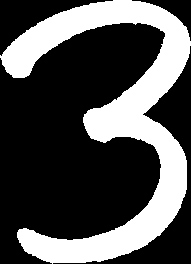

tensor([[-5.4792, -0.2227, -1.2939,  7.5989,  0.5703,  2.8836, -0.9984,  1.5386,
         -0.0155, -4.0741]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-5.4792, -0.2227, -1.2939,  7.5989,  0.5703,  2.8836, -0.9984,  1.5386,
         -0.0155, -4.0741]], device='cuda:0')
Tahmin edilen Label : 3


In [46]:
prediction = predict('handwritten3.png', model)
print("Tahmin edilen Label : {}".format(prediction))

Datasetin içinden test edilme;

In [43]:
img = test_dataset[12][0].resize_((1, 1, 28, 28)) #batch_size,channels,heights,width
label =test_dataset[12][1]

model.eval()
CUDA = torch.cuda.is_available()
if CUDA:
  inputs = inputs.cuda()
  img = img.cuda()

output = model(img)
_, predicted = torch.max(output,1)
print("Tahmin edilen Label : {}".format(predicted.item()))
print("Gerçek Label : {}".format(label))


Tahmin edilen Label : 9
Gerçek Label : 9
